In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline


# https://pypi.org/project/profanity-check/

In [3]:
df_15 = pd.read_csv('../df_15.csv')

In [4]:
df_15.columns

Index(['binary_tox', 'capitalized letters', 'character count', 'cleaner_text',
       'comment_text', 'compound', 'identity_hate', 'insult',
       'lemmatized_text', 'lgbtq hate', 'misogynist words', 'neg', 'neu',
       'neutral', 'obscene', 'pos', 'racial_ethnic slurs', 'severe_toxic',
       'special characters', 'swear words', 'threat', 'toxic', 'word count'],
      dtype='object')

In [5]:
df_15['binary_tox'] = df_15['neutral'].map(lambda x: 1 if x == 0 else 0)

In [6]:
df_15['binary_tox'].value_counts()

0    27232
1    12331
Name: binary_tox, dtype: int64

In [7]:
binary_classification = df_15.drop(columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'neutral'])

In [8]:
binary_classification.head()

,binary_tox,capitalized letters,character count,cleaner_text,comment_text,compound,lemmatized_text,lgbtq hate,misogynist words,neg,neu,pos,racial_ethnic slurs,special characters,swear words,word count
0,0,2,78,May not be a insult but still name calling Kep...,May not be a insult but still name calling Kep...,-0.2020,insult calling Kepp blocked .,0,0,0.143,0.757,0.10,0,1,0,17
1,0,2,56,is there any proof that Socialist Democrayc st...,is there any proof that Socialist Democrayc st...,0.0000,proof Socialist Democrayc exist .,0,0,0.000,1.000,0.00,0,1,0,9
2,1,2,82,You have the nerve to post these notices on my...,You have the nerve to post these notices on my...,-0.6115,spunk post note lecture foliate . truly misfor...,0,0,0.210,0.790,0.00,0,2,0,16
3,0,3,68,April 2008 Your unhelpful edits have been rve...,April 2008\n Your unhelpful edits have been rv...,0.0258,April 2008 unhelpful edits rverted . stop .,0,0,0.163,0.667,0.17,0,2,0,11
4,1,4,71,Hmmm... This says that I'm a possible sockpupp...,Hmmm... This says that I'm a possible sockpupp...,0.0000,Hmmm ... say 'm potential sockpuppet . 'm sock...,0,0,0.000,1.000,0.00,0,7,0,12


In [9]:
# Reshuffle the rows
shuffled_df = binary_classification.sample(frac=1, random_state=42)  # frac=1 means all rows, random_state for reproducibility

shuffled_df.reset_index(drop = True, inplace = True)

In [10]:
shuffled_df.head()

,binary_tox,capitalized letters,character count,cleaner_text,comment_text,compound,lemmatized_text,lgbtq hate,misogynist words,neg,neu,pos,racial_ethnic slurs,special characters,swear words,word count
0,0,220,4587,"OVERVIEW: Crunch (AGT Crunch Acquisition, LLC...","OVERVIEW:\n\nCrunch (AGT Crunch Acquisition, L...",0.9964,"OVERVIEW : Crunch ( AGT Crunch Acquisition , L...",0,0,0.007,0.882,0.112,0,144,7,686
1,0,26,1106,""" My proposed lead paragraph, which treats th...","""\n\nMy proposed lead paragraph, which treats ...",0.1901,"`` proposed lead paragraph , treat topic artic...",0,0,0.000,0.990,0.010,0,37,1,184
2,0,12,357,Yes we are editing the article: Pranic Healing...,Yes we are editing the article: Pranic Healing...,0.6517,Yes editing article : Pranic Healing behalf Co...,0,0,0.000,0.918,0.082,0,6,0,64
3,1,7,70,The Gay Guy I know you. Wuzzup? I like sad...,The Gay Guy \n\nI know you. Wuzzup? I like s...,0.4199,homophile hombre know . Wuzzup ? like sadomaso...,0,0,0.000,0.763,0.237,0,4,0,12
4,1,0,65,fuck you jzg i will have you removed as edit...,fuck you jzg \n\ni will have you removed as ed...,-0.8779,bonk jzg take_out editor_program stupid idiot,0,0,0.529,0.471,0.000,0,0,1,13


In [11]:
X = shuffled_df['lemmatized_text']
y = shuffled_df['binary_tox']

In [12]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

In [13]:
#create pipeline so i can gridsearch over both

pipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rfc', RandomForestClassifier(class_weight = 'balanced'))])

In [14]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

##these were found to be the best params after multiple gridsearches
pipe_params = {
 'rfc__max_depth': [35],
 'rfc__min_samples_leaf': [3],
 'rfc__min_samples_split': [7],
 'tvec__max_df': [0.9],
 'tvec__max_features': [10000],
 'tvec__min_df': [5],
 'tvec__ngram_range': [(1, 2)]}


In [15]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  pipe_params, # what parameters values are we searching?
              cv =5,
                 scoring = 'f1') # 5-fold cross-validation.

In [16]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rfc',
                                        RandomForestClassifier(class_weight='balanced'))]),
             param_grid={'rfc__max_depth': [35], 'rfc__min_samples_leaf': [3],
                         'rfc__min_samples_split': [7], 'tvec__max_df': [0.9],
                         'tvec__max_features': [10000], 'tvec__min_df': [5],
                         'tvec__ngram_range': [(1, 2)]},
             scoring='f1')

In [17]:
# What's the best accuracy score?

gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.7667213332742343, 0.7370980815995677)

In [18]:
# Get predictions

preds = gs.predict(X_test)


# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

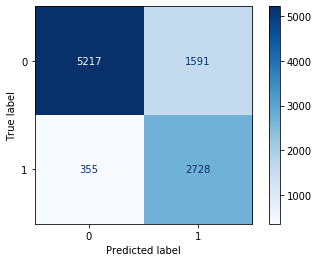

In [19]:

# View confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues');

In [20]:
from sklearn.metrics import classification_report

In [21]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.77      0.84      6808
           1       0.63      0.88      0.74      3083

    accuracy                           0.80      9891
   macro avg       0.78      0.83      0.79      9891
weighted avg       0.84      0.80      0.81      9891



In [22]:
gs.best_params_


{'rfc__max_depth': 35,
 'rfc__min_samples_leaf': 3,
 'rfc__min_samples_split': 7,
 'tvec__max_df': 0.9,
 'tvec__max_features': 10000,
 'tvec__min_df': 5,
 'tvec__ngram_range': (1, 2)}

In [23]:
from sklearn import metrics
metrics.f1_score(y_test, preds)

0.7370980815995677

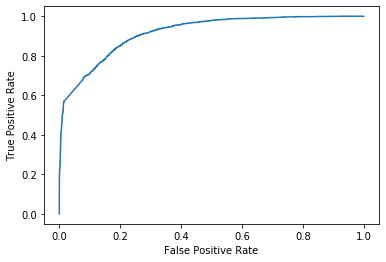

In [24]:
y_pred_prob = gs.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_prob)

# Create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [25]:
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

0.9168581314535988

In [26]:
## feature importances
# Access the best estimator (pipeline) from the grid search
best_pipeline = gs.best_estimator_

# Access the Random Forest model from the best pipeline
random_forest_model = best_pipeline.named_steps['rfc']

# Get feature importances from the Random Forest model
feature_importances = random_forest_model.feature_importances_

# Print or use the feature importances as needed
# for feature, importance in enumerate(feature_importances):
#     print(f"Feature {feature}: Importance = {importance}")

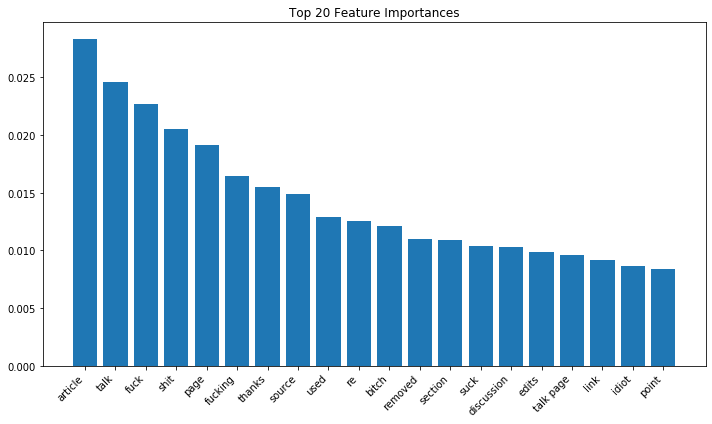

In [27]:
# Access the TfidfVectorizer from the best pipeline
tfidf_vectorizer = best_pipeline.named_steps['tvec']

# Get the feature names from the TfidfVectorizer
feature_names = tfidf_vectorizer.get_feature_names()

# Access the Random Forest model from the best pipeline
random_forest_model = best_pipeline.named_steps['rfc']

# Get feature importances from the Random Forest model
feature_importances = random_forest_model.feature_importances_

# Get the indices of the top 20 most important features
top_feature_indices = np.argsort(feature_importances)[::-1][:20]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.bar(range(20), feature_importances[top_feature_indices], align="center")
plt.xticks(range(20), np.array(feature_names)[top_feature_indices], rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [28]:
##how to get feature importances out of a pipeline

# https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214

In [29]:
## pickle model for later use, if needed:

import pickle


# Pickle the model to a file
with open('rfc_pipe_model.pkl', 'wb') as file:
    pickle.dump(gs, file)